In [13]:
import pandas as pd

df = pd.read_csv('dataset/in.tsv', sep='\t')
df.columns = ["file_name", "list_keys", "pdf2djvu/djvu2hocr", "tesseract", "textract", "pdf2djvu/djvu2hocr_tesseract"]
df = df.dropna(axis = 0)

In [18]:
# Choose which extracted text method to use as input
documents = df["tesseract"].tolist()

In [7]:
# Treatment of cleaned text: tokenisation, stemming and lemmatisation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pickle
from rich.progress import track

def cleaning(document):
    # Load English tokenizer, tagger, parser and NER
    nlp = spacy.load("en_core_web_sm")
    # Process whole documents
    document = document.replace("\\n"," ")
    doc = nlp(document)

    # Tokenisation
    token_list = []
    for token in doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_sentence =[] 

    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
            
    doc = nlp(' '.join(filtered_sentence))

    #Lematization
    lemma_word = [] 
    for token in doc:
        lemma_word.append(token.lemma_)

    #Remove punctuation
    doc = ' '.join(word.strip(string.punctuation) for word in lemma_word)

    return doc

# Call of the function for all documents
# in_documents = [cleaning(document) for document in documents]

In [8]:
import pickle
# with open('in_documents.pkl', 'wb') as f:
#     pickle.dump(in_documents, f)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

vectorizer = TfidfVectorizer(stop_words='english')
trans = vectorizer.fit_transform(in_documents) # input must be a list of string aka whole text in one str

svd = TruncatedSVD(100)
X = svd.fit_transform(trans)

# Kmeans method
true_k = 9
model_k = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k.fit(X)

order_centroids = model_k.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


In [22]:
from fcmeans import FCM
# Soft clustering Method aka c-means clustering
model_c = FCM(n_clusters=6)
model_c.fit(X)

fcm_centers = model_c.centers
fcm_labels = model_c.predict(X)


In [35]:
print(model_c.__dict__)

{'u': DeviceArray([[0.16666669, 0.16666669, 0.16666669, 0.16666669, 0.16666657,
              0.16666667],
             [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666669,
              0.16666667],
             [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
              0.16666669],
             ...,
             [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666669,
              0.16666669],
             [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666669,
              0.16666667],
             [0.16666667, 0.16666661, 0.16666667, 0.16666661, 0.16666678,
              0.16666669]], dtype=float32), 'centers': DeviceArray([[ 3.77257526e-01,  1.65914893e-02,  9.89448279e-03,
              -2.07644398e-03,  1.01974956e-03,  1.65537628e-03,
               1.82567979e-03, -2.05723546e-03, -6.55808195e-04,
               3.49287549e-03, -6.16758270e-03,  1.27869227e-03,
               2.76160217e-03,  2.32991297e-03, -8.69899814e-04,
               3.

<AxesSubplot:>

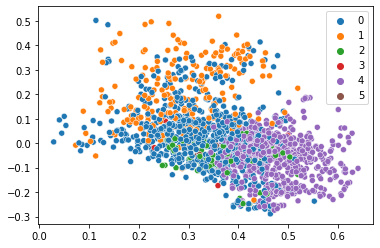

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
# Plot C-means
x = X[:,0]
y = X[:,1]
sns.scatterplot(x=x, y=y, hue=fcm_labels, palette='tab10')
# plot result
# f, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].scatter(X[:,0], X[:,1], alpha=.1)
# axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
# axes[1].scatter(fcm_centers[:,6], fcm_centers[:,6], marker="+", s=500, c='w')
# plt.show()

<AxesSubplot:>

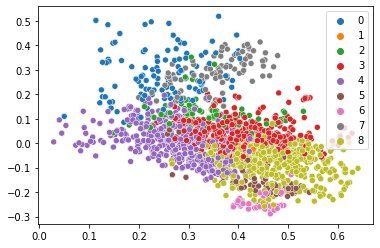

In [11]:
# Plot K-means
x = X[:,0]
y = X[:,1]
df = pd.DataFrame({'x': x,'y': y, 'model': model_k.labels_})

sns.scatterplot(x=x, y=y, hue=model_k.labels_, palette='tab10')